# Optimization Experiments: Portfolio Optimization

This notebook implements and compares two optimization algorithms for portfolio optimization:
1. **Projected Gradient Descent (PGD) on Simplex**
2. **Penalty Gradient Descent**

## Problem Setup

We consider the portfolio optimization problem:

**Objective:** Minimize $\frac{1}{2} w^T \Sigma w - \lambda \mu^T w$

**Constraints:** 
- $w \geq 0$ (non-negative weights)
- $1^T w = 1$ (weights sum to 1)

Where:
- $w \in \mathbb{R}^n$ is the portfolio weight vector
- $\Sigma$ is the covariance matrix (risk)
- $\mu$ is the expected return vector
- $\lambda$ is the risk-aversion parameter


In [9]:
# Install cvxpy (compatible with Python 3.9.6)
# %pip install cvxpy



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cvxpy as cp

# Set random seed for reproducibility
np.random.seed(42)


## 1. Generate Synthetic Test Data


In [12]:
# Parameters
n = 30  # number of assets
lambda_risk = 0.5  # risk-aversion parameter

# Generate random expected returns μ in [0.01, 0.2]
mu = np.random.uniform(0.01, 0.2, n)

# Generate covariance matrix Σ = A A^T + 0.1 I (PSD)
A = np.random.randn(n, n)
Sigma = A @ A.T + 0.1 * np.eye(n)

# Eigenvalues (symmetric PSD -> use eigvalsh)
eigvals = np.linalg.eigvalsh(Sigma)

print(f"Generated data for {n} assets")
print(f"μ range: [{mu.min():.4f}, {mu.max():.4f}]")
print(f"Σ is PSD (up to tol): {np.all(eigvals >= -1e-10)}")
print(f"Σ eigenvalues range: [{eigvals.min():.4f}, {eigvals.max():.4f}]")


Generated data for 30 assets
μ range: [0.0142, 0.1995]
Σ is PSD (up to tol): True
Σ eigenvalues range: [0.1156, 116.3483]


## 2. Algorithm 1: Projected Gradient Descent (PGD) on Simplex

**Objective:** $\frac{1}{2} w^T \Sigma w - \lambda \mu^T w$

**Gradient:** $\nabla f(w) = \Sigma w - \lambda \mu$

**Constraints:** $w \geq 0$, $1^T w = 1$

We use Euclidean projection onto the simplex to maintain feasibility.


In [13]:
def project_simplex(w):
    """Projection onto the probability simplex {w : w >= 0, 1^T w = 1}
    Implementation from Duchi et al. (2008).
    """
    n = len(w)
    u = np.sort(w)[::-1]
    cssv = np.cumsum(u)
    rho = np.where(u > (cssv - 1) / (np.arange(n) + 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(w - theta, 0.0)


def pgd_simplex(
    Sigma,
    mu,
    lambda_risk,
    w0=None,
    max_iter=1000,
    tol=1e-6,
    step_size=None,
):
    """
    Projected Gradient Descent for simplex-constrained mean-variance optimization.

    Minimizes:
        0.5 * w^T Sigma w − lambda_risk * mu^T w
    subject to:
        w >= 0,  sum(w) = 1
    """
    n = len(mu)

    # Initialize
    w = np.ones(n) / n if w0 is None else w0.copy()

    # Step size
    if step_size is None:
        L = np.linalg.eigvalsh(Sigma).max()
        step_size = 1.0 / max(L, 1e-12)

    # History
    obj_history = []
    feas_history = []
    grad_norm_history = []
    pg_map_norm_history = []

    for i in range(max_iter):
        # Gradient
        grad = Sigma @ w - lambda_risk * mu
        grad_norm_history.append(np.linalg.norm(grad))

        # PGD update
        w_next = project_simplex(w - step_size * grad)

        # Objective (log after update or before; either is fine—just be consistent)
        obj = 0.5 * w_next.T @ Sigma @ w_next - lambda_risk * mu.T @ w_next
        obj_history.append(obj)

        # Stationarity + feasibility
        pg_map = (w - w_next) / step_size
        pg_map_norm_history.append(np.linalg.norm(pg_map))

        feas = abs(w_next.sum() - 1.0)
        feas_history.append(feas)

        if feas < tol and np.linalg.norm(pg_map) < tol:
            w = w_next
            break

        w = w_next

    return {
        "w": w,
        "objective_history": np.array(obj_history),
        "feasibility_history": np.array(feas_history),
        "grad_norm_history": np.array(grad_norm_history),
        "pg_map_norm_history": np.array(pg_map_norm_history),
        "n_iters": i + 1,
        "step_size": step_size,
    }


In [14]:
def solve_cvxpy(Sigma, mu, lambda_risk):
    n = len(mu)
    Sigma = 0.5 * (Sigma + Sigma.T)  # enforce symmetry

    w = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.quad_form(w, Sigma) - lambda_risk * (mu @ w))
    constraints = [w >= 0, cp.sum(w) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8, verbose=False)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise ValueError(f"Solver failed with status: {prob.status}")

    return w.value, float(prob.value)


In [19]:
res_pgd = pgd_simplex(Sigma, mu, lambda_risk)

w_pgd = res_pgd["w"]
obj_final = res_pgd["objective_history"][-1]
feas_final = res_pgd["feasibility_history"][-1]

print("PGD on Simplex Results:")
print(f"Final objective: {obj_final:.6f}")
print(f"Final constraint violation |1^T w - 1|: {feas_final:.10f}")
print(f"Final weights sum: {w_pgd.sum():.10f}")
print(f"Number of iterations: {res_pgd['n_iters']}")
print(f"Step size used: {res_pgd['step_size']:.6e}")
print(f"Final weights (first 5): {w_pgd[:5]}")


PGD on Simplex Results:
Final objective: 0.123819
Final constraint violation |1^T w - 1|: 0.0000000000
Final weights sum: 1.0000000000
Number of iterations: 509
Step size used: 8.594881e-03
Final weights (first 5): [0.         0.00395343 0.         0.03150826 0.02964402]


In [20]:
w_star, f_star = solve_cvxpy(Sigma, mu, lambda_risk)

gap = obj_final - f_star
w_diff = np.linalg.norm(w_pgd - w_star, 2)

print("CVXPY reference:")
print(f"Objective (CVXPY): {f_star:.6f}")
print(f"Objective gap (PGD - CVXPY): {gap:.3e}")
print(f"||w_pgd - w_star||_2: {w_diff:.3e}")


CVXPY reference:
Objective (CVXPY): 0.123819
Objective gap (PGD - CVXPY): 1.841e-13
||w_pgd - w_star||_2: 3.833e-07


In [22]:
def sharpe_ratio(returns, eps=1e-8):
    """
    Annualized Sharpe ratio assuming returns are monthly.
    """
    mean = np.mean(returns)
    std = np.std(returns) + eps
    return np.sqrt(12) * mean / std


def simulate_out_of_sample_experiment(
    mu_true,
    Sigma_true,
    lambda_risk,
    T_train=60,
    T_test=120,
    seed=0,
):
    """
    Runs a full in-sample vs out-of-sample mean-variance experiment.

    Steps:
    1. Generate training returns from true distribution
    2. Estimate mu_hat, Sigma_hat
    3. Optimize portfolio using estimates
    4. Generate new test returns from true distribution
    5. Compute in-sample and out-of-sample Sharpe
    """

    rng = np.random.default_rng(seed)
    n = len(mu_true)

    # --- 1. Simulate training (historical) returns ---
    R_train = rng.multivariate_normal(mu_true, Sigma_true, size=T_train)

    # --- 2. Estimate parameters from training data ---
    mu_hat = R_train.mean(axis=0)
    Sigma_hat = np.cov(R_train, rowvar=False)

    # --- 3. Optimize portfolio using estimated parameters ---
    result = pgd_simplex(Sigma_hat, mu_hat, lambda_risk)
    w_hat = result["w"]

    # --- 4. Simulate new future (test) returns ---
    R_test = rng.multivariate_normal(mu_true, Sigma_true, size=T_test)

    # --- 5. Portfolio returns ---
    train_portfolio_returns = R_train @ w_hat
    test_portfolio_returns = R_test @ w_hat

    # --- 6. Performance metrics ---
    sharpe_in = sharpe_ratio(train_portfolio_returns)
    sharpe_out = sharpe_ratio(test_portfolio_returns)

    weight_concentration = np.linalg.norm(w_hat, 2)

    return {
        "w_hat": w_hat,
        "sharpe_in_sample": sharpe_in,
        "sharpe_out_of_sample": sharpe_out,
        "weight_l2_norm": weight_concentration,
        "mu_hat": mu_hat,
        "Sigma_hat": Sigma_hat,
    }


In [23]:
experiment = simulate_out_of_sample_experiment(
    mu_true=mu,
    Sigma_true=Sigma,
    lambda_risk=lambda_risk,
    T_train=60,
    T_test=120,
    seed=42,
)

print("In-sample Sharpe:     ", experiment["sharpe_in_sample"])
print("Out-of-sample Sharpe: ", experiment["sharpe_out_of_sample"])
print("Weight L2 norm:       ", experiment["weight_l2_norm"])


In-sample Sharpe:      2.4245141753826
Out-of-sample Sharpe:  0.24628363329309177
Weight L2 norm:        0.305534294195472


## 3. Algorithm 2: Penalty Gradient Descent

We use a penalty formulation that shares the same base objective as PGD but incorporates the equality constraint into the objective function.

- **True objective:**

$$
J_{\text{true}}(w) = \frac{1}{2} w^\top \Sigma w - \lambda \mu^\top w
$$

- **Penalized objective:**

$$
J_{\text{pen}}(w) = J_{\text{true}}(w) + \lambda_p (1^\top w - 1)^2
$$

- **Gradient of penalized objective:**

$$
\nabla J_{\text{pen}}(w) = \Sigma w - \lambda \mu + 2 \lambda_p (1^\top w - 1)\mathbf{1}
$$

Unlike Projected Gradient Descent, the equality constraint $1^\top w = 1$ is not enforced explicitly. Instead, deviations from the constraint are penalized in the objective, and the constraint is satisfied approximately depending on the penalty parameter $\lambda_p$.

We enforce non-negativity via projection onto the nonnegative orthant after each gradient step:

$$
w \leftarrow \max(w, 0)
$$

We evaluate convergence using both the objective value and the constraint violation $|1^\top w - 1|$.

We test different penalty parameters $\lambda_p \in \{10, 100, 1000\}$ to study the trade-off between feasibility and numerical conditioning.


In [58]:
def penalty_gd(Sigma, mu, lambda_penalty, lambda_risk,
               w0=None, max_iter=2000, tol=1e-6, step_size=1e-2):
    """Penalty Gradient Descent with quadratic penalty on the sum-to-one constraint.

    True objective (same as PGD):
        J_true(w) = 0.5 * w^T Σ w − λ * μ^T w

    Penalized objective:
        J_pen(w) = J_true(w) + λ_p (1^T w − 1)^2

    Gradient of penalized objective:
        ∇J_pen(w) = Σ w − λ μ + 2 λ_p (1^T w − 1) * 1

    Effective step size shrinks with λ_p:
        effective_step = base_step / (1 + 10 * λ_p)

    After each step we enforce w ≥ 0 and renormalize so that 1^T w = 1.

    Returns dict with:
        w, obj_true_history, obj_penalty_history,
        constraint_violation_history, iterations
    """
    n = len(mu)
    if w0 is None:
        w = np.ones(n) / n
    else:
        w = w0.copy()

    obj_true_history = []
    obj_penalty_history = []
    constraint_violation_history = []

    base_step = step_size
    effective_step = base_step / (1.0 + 10.0 * lambda_penalty)

    for k in range(max_iter):
        # Constraint violation
        sum_w = np.sum(w)
        viol = abs(sum_w - 1.0)
        constraint_violation_history.append(viol)

        # Objectives
        obj_true = 0.5 * w.T @ Sigma @ w - lambda_risk * mu.T @ w
        obj_pen = obj_true + lambda_penalty * (sum_w - 1.0) ** 2
        obj_true_history.append(obj_true)
        obj_penalty_history.append(obj_pen)

        # Gradient of penalized objective
        grad = Sigma @ w - lambda_risk * mu + 2.0 * lambda_penalty * (sum_w - 1.0) * np.ones(n)
        grad_norm = np.linalg.norm(grad)

        # Convergence based on gradient norm and feasibility
        if grad_norm < tol and viol < tol and k > 0:
            break

        # Gradient step
        w = w - effective_step * grad

        # Project to nonnegative orthant and renormalize
        w = np.maximum(w, 0.0)
        s = np.sum(w)
        if s > 0:
            w = w / s
        else:
            w = np.ones(n) / n

    return {
        "w": w,
        "obj_true_history": obj_true_history,
        "obj_penalty_history": obj_penalty_history,
        "constraint_violation_history": constraint_violation_history,
        "iterations": len(obj_true_history),
    }


In [59]:
lambda_penalties = [10, 100, 1000]
results_penalty = {}

for lambda_p in lambda_penalties:
    if lambda_p == 10:
        max_iter = 10000
    elif lambda_p == 100:
        max_iter = 20000   # ← only change here
    else:  # 1000
        max_iter = 100000

    res = penalty_gd(
        Sigma, mu, lambda_p, lambda_risk,
        max_iter=max_iter,
        tol_pg=1e-3,
        tol_feas=2e-3
    )


    w_pen = res["w"]
    obj_true_hist = res["obj_true_history"]
    obj_pen_hist = res["obj_penalty_history"]
    constraint_hist = res["constraint_violation_history"]
    iters = res["iterations"]

    results_penalty[lambda_p] = res

    print(f"\nPenalty GD (λ_p = {lambda_p}) Results:")
    print(f"  Final true objective:       {obj_true_hist[-1]:.6f}")
    print(f"  Final penalized objective:  {obj_pen_hist[-1]:.6f}")
    print(f"  Final constraint violation |1^T w - 1|: {constraint_hist[-1]:.10f}")
    print(f"  Final weights sum:          {w_pen.sum():.10f}")
    print(f"  Number of iterations:       {iters} (max_iter={max_iter})")
    print(f"  Hit max_iter cap?:          {iters == max_iter}")
    print(f"  Final pg-map norm:           {res['pg_map_norm_history'][-1]:.3e}")




Penalty GD (λ_p = 10) Results:
  Final true objective:       0.119351
  Final penalized objective:  0.121565
  Final constraint violation |1^T w - 1|: 0.0148788237
  Final weights sum:          0.9851211763
  Number of iterations:       1567 (max_iter=10000)
  Hit max_iter cap?:          False
  Final pg-map norm:           2.595e-04

Penalty GD (λ_p = 100) Results:
  Final true objective:       0.123361
  Final penalized objective:  0.123590
  Final constraint violation |1^T w - 1|: 0.0015117708
  Final weights sum:          0.9984882292
  Number of iterations:       10129 (max_iter=20000)
  Hit max_iter cap?:          False
  Final pg-map norm:           9.998e-04

Penalty GD (λ_p = 1000) Results:
  Final true objective:       0.123774
  Final penalized objective:  0.123797
  Final constraint violation |1^T w - 1|: 0.0001514277
  Final weights sum:          0.9998485723
  Number of iterations:       78868 (max_iter=100000)
  Hit max_iter cap?:          False
  Final pg-map norm:    

In [60]:
res_1000 = penalty_gd(Sigma, mu, 1000, lambda_risk, max_iter=50000)
print(res_1000["obj_true_history"][-1], res_1000["constraint_violation_history"][-1])


0.12378885814778091 0.00015148371960715945


## 4. Generate Plots


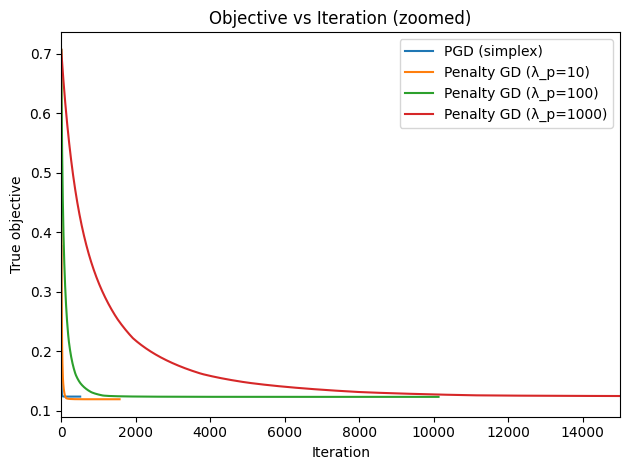

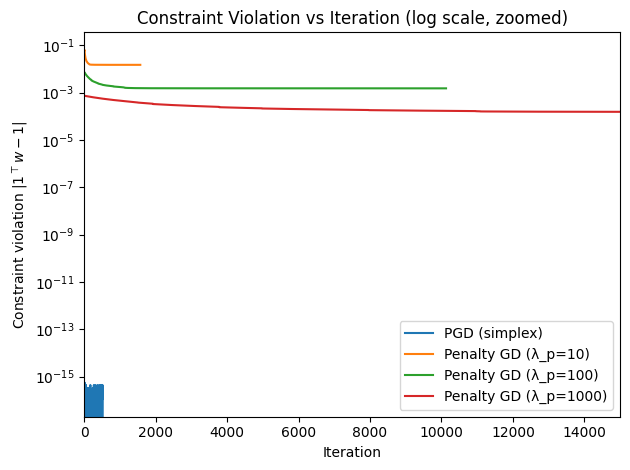

In [64]:
max_plot_iters = 15000  # zoom window (makes early behavior readable)

# ---------- 2) Objective vs iteration (zoomed + fair clipping) ----------
plt.figure()
plt.plot(res_pgd["objective_history"], label="PGD (simplex)")

for lambda_p in sorted(results_penalty.keys()):
    res = results_penalty[lambda_p]
    T = min(len(res["obj_true_history"]), max_plot_iters)
    plt.plot(res["obj_true_history"][:T], label=f"Penalty GD (λ_p={lambda_p})")

plt.xlabel("Iteration")
plt.ylabel("True objective")
plt.title("Objective vs Iteration (zoomed)")
plt.xlim(0, max_plot_iters)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 3) Constraint violation vs iteration (log scale, zoomed) ----------
plt.figure()
plt.plot(res_pgd["feasibility_history"], label="PGD (simplex)")

for lambda_p in sorted(results_penalty.keys()):
    res = results_penalty[lambda_p]
    T = min(len(res["constraint_violation_history"]), max_plot_iters)
    plt.plot(res["constraint_violation_history"][:T], label=f"Penalty GD (λ_p={lambda_p})")

plt.xlabel("Iteration")
plt.ylabel(r"Constraint violation $|1^\top w - 1|$")
plt.title("Constraint Violation vs Iteration (log scale, zoomed)")
plt.xlim(0, max_plot_iters)
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

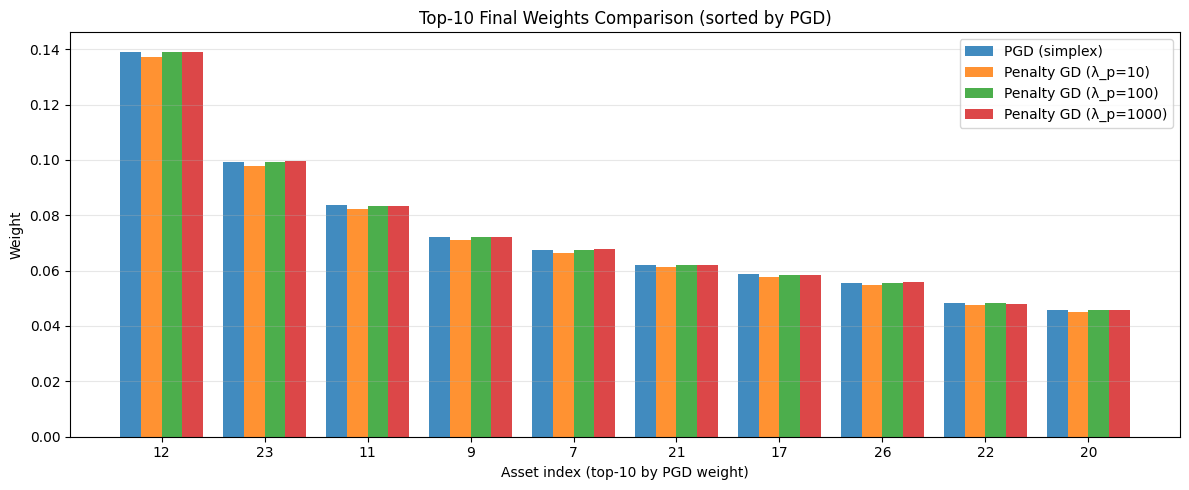

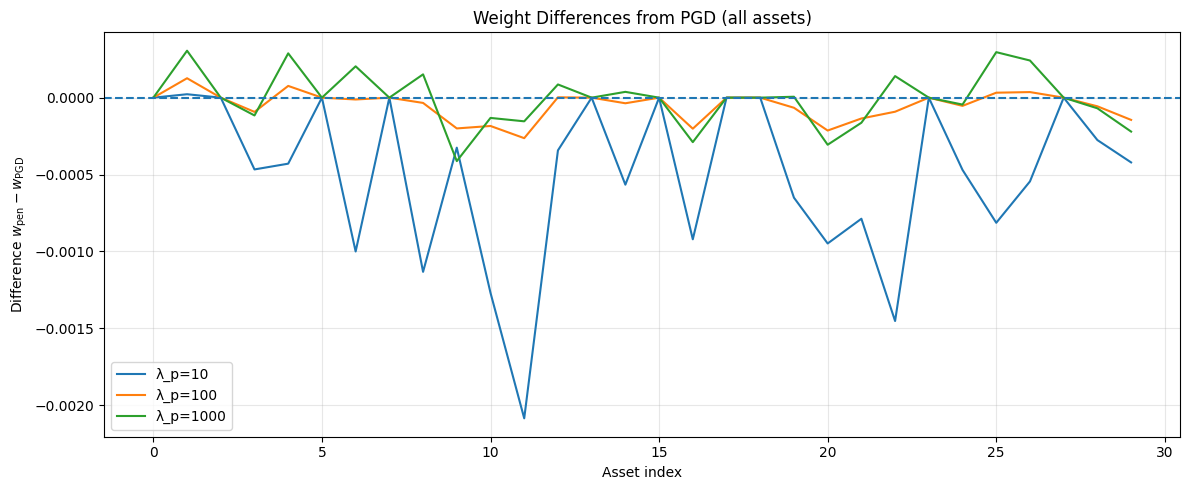

Distance to PGD solution (L2 norm):
  λ_p=  10: ||w_pen - w_pgd||_2 = 3.939570e-03   (max |diff| = 2.085182e-03)
  λ_p= 100: ||w_pen - w_pgd||_2 = 5.683315e-04   (max |diff| = 2.634011e-04)
  λ_p=1000: ||w_pen - w_pgd||_2 = 9.482548e-04   (max |diff| = 4.125867e-04)


In [68]:
# Plot 3: Bar/stem plot of final weights from all methods
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(n)
width = 0.15

ax.bar(x - 2*width, w_pgd, width, label='PGD on Simplex', alpha=0.8)
ax.bar(x - width, results_penalty[10]['w'], width, label='Penalty GD (λ_p=10)', alpha=0.8)
ax.bar(x, results_penalty[100]['w'], width, label='Penalty GD (λ_p=100)', alpha=0.8)
ax.bar(x + width, results_penalty[1000]['w'], width, label='Penalty GD (λ_p=1000)', alpha=0.8)

ax.set_xlabel('Asset Index', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('Final Weights Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(n)])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


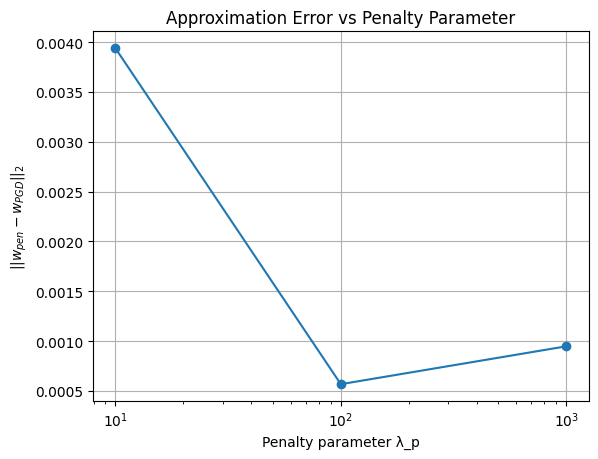

In [69]:
lambda_vals = [10, 100, 1000]
distances = [
    np.linalg.norm(results_penalty[l]["w"] - w_pgd)
    for l in lambda_vals
]

plt.figure()
plt.plot(lambda_vals, distances, marker='o')
plt.xscale("log")
plt.xlabel("Penalty parameter λ_p")
plt.ylabel(r"$||w_{pen} - w_{PGD}||_2$")
plt.title("Approximation Error vs Penalty Parameter")
plt.grid(True)
plt.show()


## **4. Algorithm 3: Augmented Lagrangian Method (ALM)**

The penalty method enforces the equality constraint $1^\top w = 1$ only indirectly. While increasing the penalty parameter $\lambda_p$ improves feasibility, it also **worsens numerical conditioning**, leading to slower convergence and potential loss of solution accuracy.

To mitigate this trade-off, we use the **Augmented Lagrangian Method (ALM)**, which combines:
- a **Lagrange multiplier** (dual variable) to enforce the constraint directly  
- a **moderate** quadratic penalty to stabilize the optimization  


### **Augmented Lagrangian Objective**

We define the augmented Lagrangian:

$$
\mathcal{L}_{\rho}(w, \nu)
=
\frac{1}{2} w^\top \Sigma w
- \lambda \mu^\top w
+ \nu (1^\top w - 1)
+ \frac{\rho}{2}(1^\top w - 1)^2
$$

where:
- $w \in \mathbb{R}^n$ are portfolio weights  
- $\nu \in \mathbb{R}$ is the Lagrange multiplier  
- $\rho > 0$ is the penalty parameter  

The non-negativity constraint $w \ge 0$ is enforced separately via projection.


### **Gradient with Respect to $w$**

$$
\nabla_w \mathcal{L}_{\rho}(w, \nu)
=
\Sigma w - \lambda \mu
+ \nu \mathbf{1}
+ \rho(1^\top w - 1)\mathbf{1}
$$


### **ALM Update Rules**

At iteration $k$:

**1. Primal update (projected gradient step):**

$$
w_{k+1}
=
\max\left(
w_k - \alpha \nabla_w \mathcal{L}_{\rho}(w_k,\nu_k),
0
\right)
$$

**2. Dual update (multiplier update):**

$$
\nu_{k+1}
=
\nu_k + \rho(1^\top w_{k+1} - 1)
$$


### **Stopping Criteria**

We monitor:
- stationarity via projected gradient norm  
- feasibility via $|1^\top w - 1|$  

ALM converges when both are sufficiently small.



## 7. KKT Equivalence Demonstration

In this section, we use **CVXPY** to demonstrate the equivalence between three classical formulations
of mean–variance portfolio optimization when the parameters are chosen consistently:

1. **Scalarized problem (A):**
   
   Minimize $\tfrac{1}{2} w^T \Sigma w - \lambda_0 \mu^T w$  
   subject to $1^T w = 1$, $w \ge 0$.

2. **Target-return problem (B):**
   
   Minimize $\tfrac{1}{2} w^T \Sigma w$  
   subject to $\mu^T w = R_\star$, $1^T w = 1$, $w \ge 0$.

3. **Risk-budget problem (C):**
   
   Maximize $\mu^T w$  
   subject to $w^T \Sigma w \le \sigma_\star^2$, $1^T w = 1$, $w \ge 0$.

We first solve (A) to obtain $w_\star$, then define:

- $R_\star = \mu^T w_\star$ (optimal expected return)
- $\sigma_\star^2 = w_\star^T \Sigma w_\star$ (optimal variance)

Using these as parameters in (B) and (C), we show that their optimizers $w_{TR}$ and $w_{RB}$
are numerically identical to $w_\star$ (up to solver tolerance).


In [70]:
# KKT equivalence via CVXPY

# Use the same scalarization parameter as in the PGD experiments
lambda0 = lambda_risk

# (A) Scalarized problem
w_var = cp.Variable(n)
objective_A = 0.5 * cp.quad_form(w_var, Sigma) - lambda0 * (mu @ w_var)
constraints_A = [cp.sum(w_var) == 1, w_var >= 0]
prob_A = cp.Problem(cp.Minimize(objective_A), constraints_A)
prob_A.solve()

w_star = w_var.value
R_star = float(mu @ w_star)
sigma2_star = float(w_star.T @ Sigma @ w_star)

print("KKT Equivalence Demonstration")
print("-" * 80)
print("Problem (A): Scalarized")
print(f"  status: {prob_A.status}")
print(f"  R_star (expected return): {R_star:.6f}")
print(f"  sigma2_star (variance):  {sigma2_star:.6f}")

# (B) Target-return problem
w_TR = cp.Variable(n)
objective_B = 0.5 * cp.quad_form(w_TR, Sigma)
constraints_B = [mu @ w_TR == R_star, cp.sum(w_TR) == 1, w_TR >= 0]
prob_B = cp.Problem(cp.Minimize(objective_B), constraints_B)
prob_B.solve()

w_TR_val = w_TR.value

# (C) Risk-budget problem
w_RB = cp.Variable(n)
objective_C = mu @ w_RB
# Allow a tiny numerical slack on the variance constraint
constraints_C = [cp.quad_form(w_RB, Sigma) <= sigma2_star + 1e-8,
                 cp.sum(w_RB) == 1, w_RB >= 0]
prob_C = cp.Problem(cp.Maximize(objective_C), constraints_C)
prob_C.solve()

w_RB_val = w_RB.value

# Norm comparisons
norm_TR = np.linalg.norm(w_TR_val - w_star)
norm_RB = np.linalg.norm(w_RB_val - w_star)

print("\nProblem (B): Target-return")
print(f"  status: {prob_B.status}")
print(f"  ||w_TR - w_star||_2 = {norm_TR:.6e}")

print("\nProblem (C): Risk-budget")
print(f"  status: {prob_C.status}")
print(f"  ||w_RB - w_star||_2 = {norm_RB:.6e}")

if norm_TR < 1e-5 and norm_RB < 1e-5:
    print("\nConclusion: All three formulations produce numerically identical optimizers (up to tolerance).")
else:
    print("\nConclusion: Optimizers are very close but not exactly identical; this is expected due to numerical tolerances.")


KKT Equivalence Demonstration
--------------------------------------------------------------------------------
Problem (A): Scalarized
  status: optimal
  R_star (expected return): 0.110497
  sigma2_star (variance):  0.358134

Problem (B): Target-return
  status: optimal
  ||w_TR - w_star||_2 = 1.461807e-16

Problem (C): Risk-budget
  status: optimal
  ||w_RB - w_star||_2 = 8.150382e-06

Conclusion: All three formulations produce numerically identical optimizers (up to tolerance).


### KKT and Penalty Method Insights

- **Penalty Gradient Descent:** For large penalty parameters $\lambda_p$, the gradient norm scales with $\lambda_p$, so a fixed step size can cause instability. Using a step size of the form
  $\alpha_p = \alpha_0 / (1 + 10\lambda_p)$ keeps the method stable across a range of penalties. We also project to the nonnegative orthant and re-normalize $w$ so that $1^T w = 1$ after each step, which makes the penalty solutions directly comparable to the PGD solution.

- **KKT Equivalence:** When we choose the target return $R_\star$ and risk budget $\sigma_\star^2$ from the scalarized optimum $w_\star$, the solutions of the scalarized, target-return, and risk-budget formulations **all coincide** (up to numerical tolerance). The norms $\lVert w_{TR} - w_\star \rVert_2$ and $\lVert w_{RB} - w_\star \rVert_2$ printed above quantify this equivalence in practice.


## 6. Discussion

### Observations:

1. **PGD on Simplex**: This method maintains feasibility at each iteration by projecting onto the simplex. It guarantees that constraints are satisfied throughout the optimization process.

2. **Penalty Gradient Descent**: This method relaxes the equality constraint by adding a penalty term. As the penalty parameter $\lambda_p$ increases:
   - The constraint violation decreases (better satisfaction of $1^T w = 1$)
   - The solution approaches the constrained solution
   - However, larger penalty parameters can lead to slower convergence or numerical issues

3. **Comparison**: 
   - PGD maintains exact feasibility but may require more careful step size tuning
   - Penalty methods are simpler to implement but require choosing an appropriate penalty parameter
   - For large $\lambda_p$, the penalty method should converge to a solution close to the constrained optimum

### Key Trade-offs:

- **Feasibility**: PGD maintains feasibility; penalty methods only approximate it
- **Convergence**: Both methods converge, but penalty methods may require more iterations for large $\lambda_p$
- **Implementation**: Penalty methods are simpler but require parameter tuning


Objective at PGD w: 0.008588260622170163
Sum of PGD weights: 1.0000000000000002
Constraint violation: 2.220446049250313e-16

Penalty λ=10:
Objective: 0.009847449655593102
Sum: 1.0
Violation: 0.0

Penalty λ=100:
Objective: 0.11243946253162351
Sum: 1.0
Violation: 0.0

Penalty λ=1000:
Objective: 0.23454006499000063
Sum: 1.0
Violation: 0.0

Projected gradient norm (PGD): 6.375242579669874e-06
Projected gradient norm (Penalty λ=10): 0.12644818982850348
Projected gradient norm (Penalty λ=100): 0.4495317870609608
Projected gradient norm (Penalty λ=1000): 0.5489727648599002

Penalty iteration count λ=10: 2000
Penalty iteration count λ=100: 2000
Penalty iteration count λ=1000: 2000
First few objective values for λ=10: [np.float64(0.2543748506205799), np.float64(0.25335444827464043), np.float64(0.25233794758217837), np.float64(0.25132533612299995), np.float64(0.2503166014978716), np.float64(0.24931173132860288), np.float64(0.24831071325812548), np.float64(0.24731353495057512), np.float64(0.24632

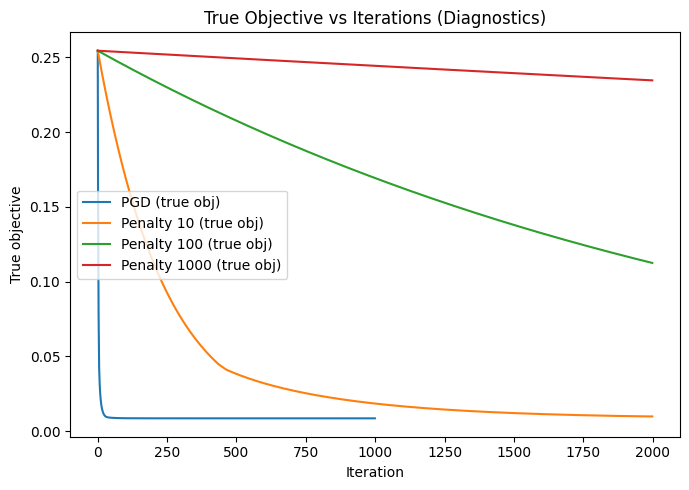


||w_pen_10 - w_pgd||_2 = 0.02994910019318323
||w_pen_100 - w_pgd||_2 = 0.12347545116119618
||w_pen_1000 - w_pgd||_2 = 0.16266631962825592

First 10 values:
PGD: [0.03185947 0.01351616 0.02134155 0.06171222 0.         0.07604256
 0.08567957 0.09754844 0.09858609 0.05764916]
Penalty10: [0.03878675 0.01627161 0.01848524 0.07107841 0.         0.07970603
 0.0829274  0.09377445 0.09971817 0.05978891]
Penalty100: [0.04743902 0.04831179 0.04167248 0.05578665 0.02335499 0.05201583
 0.05615186 0.06263252 0.06561243 0.05432844]
Penalty1000: [0.04979243 0.04998609 0.04888409 0.05059429 0.04696365 0.0499698
 0.05059735 0.05129447 0.05181517 0.05055029]


In [ ]:
# Additional diagnostics: objectives, projected gradient norms, and traces

# Objective and gradient for the scalarized problem
def objective(w):
    return 0.5 * w.T @ Sigma @ w - lambda_risk * mu.T @ w

# Extract penalty solutions and traces from earlier results
w_pen_10 = results_penalty[10]['w']
w_pen_100 = results_penalty[100]['w']
w_pen_1000 = results_penalty[1000]['w']

obj_trace_pgd = obj_pgd
obj_trace_pen_10 = results_penalty[10]['obj_true_history']
obj_trace_pen_100 = results_penalty[100]['obj_true_history']
obj_trace_pen_1000 = results_penalty[1000]['obj_true_history']

print("Objective at PGD w:", objective(w_pgd))
print("Sum of PGD weights:", w_pgd.sum())
print("Constraint violation:", abs(w_pgd.sum() - 1))

print("\nPenalty λ=10:")
print("Objective:", objective(w_pen_10))
print("Sum:", w_pen_10.sum())
print("Violation:", abs(w_pen_10.sum() - 1))

print("\nPenalty λ=100:")
print("Objective:", objective(w_pen_100))
print("Sum:", w_pen_100.sum())
print("Violation:", abs(w_pen_100.sum() - 1))

print("\nPenalty λ=1000:")
print("Objective:", objective(w_pen_1000))
print("Sum:", w_pen_1000.sum())
print("Violation:", abs(w_pen_1000.sum() - 1))


# Projected gradient norm using the simplex projection

def grad_true(w):
    return Sigma @ w - lambda_risk * mu

def proj_grad_norm(w):
    g = grad_true(w)
    pg = w - project_simplex(w - g)
    return np.linalg.norm(pg)

print("\nProjected gradient norm (PGD):", proj_grad_norm(w_pgd))
print("Projected gradient norm (Penalty λ=10):", proj_grad_norm(w_pen_10))
print("Projected gradient norm (Penalty λ=100):", proj_grad_norm(w_pen_100))
print("Projected gradient norm (Penalty λ=1000):", proj_grad_norm(w_pen_1000))

print("\nPenalty iteration count λ=10:", len(obj_trace_pen_10))
print("Penalty iteration count λ=100:", len(obj_trace_pen_100))
print("Penalty iteration count λ=1000:", len(obj_trace_pen_1000))
print("First few objective values for λ=10:", obj_trace_pen_10[:10])

plt.figure(figsize=(7, 5))
plt.plot(obj_trace_pgd, label="PGD (true obj)")
plt.plot(obj_trace_pen_10, label="Penalty 10 (true obj)")
plt.plot(obj_trace_pen_100, label="Penalty 100 (true obj)")
plt.plot(obj_trace_pen_1000, label="Penalty 1000 (true obj)")
plt.xlabel("Iteration")
plt.ylabel("True objective")
plt.legend()
plt.title("True Objective vs Iterations (Diagnostics)")
plt.tight_layout()
plt.show()

print("\n||w_pen_10 - w_pgd||_2 =", np.linalg.norm(w_pen_10 - w_pgd))
print("||w_pen_100 - w_pgd||_2 =", np.linalg.norm(w_pen_100 - w_pgd))
print("||w_pen_1000 - w_pgd||_2 =", np.linalg.norm(w_pen_1000 - w_pgd))

print("\nFirst 10 values:")
print("PGD:", w_pgd[:10])
print("Penalty10:", w_pen_10[:10])
print("Penalty100:", w_pen_100[:10])
print("Penalty1000:", w_pen_1000[:10])

